<a href="https://colab.research.google.com/github/WuzI38/Data/blob/main/MidiGenFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generation with LSTM neural network - in progress

## Download data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download programgeek01/anime-music-midi

100% 707k/707k [00:00<00:00, 1.53MB/s]
100% 707k/707k [00:00<00:00, 1.53MB/s]


In [5]:
# Debug
!pip install -Uqq ipdb --use-deprecated=legacy-resolver
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you'll have ipython 8.11.0 which is incompatible.


In [6]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [7]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [8]:
import os
from music21 import *
from fractions import Fraction

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

### Extracting notes and chords
After analysing the data for some time I've noticed some important things:
* All notes have length of x/12, where x is a natural number
* Some notes have the same offset as others, so they must be removed 
* Some notes have offsets less than the offset of the preceding + the length of the preceding note, thus the preceding notes must be trimmed to create sequence

In [9]:
import music21
def fragmentise(midi_stream: music21.stream.Score) -> list:
  return [part.flat.notes for part in midi_stream.parts]

In [10]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece: music21.stream.Score) -> list:
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
    elif isinstance(nt, chord.Chord):
      pitch = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitch = ' '.join(pitch)
    ql = nt.duration.quarterLength
    if len(all_notes) > 0: 
      if nt.offset == all_notes[-1][0]: # Remove notes with the same offset as others
        continue
      if all_notes[-1][0] + all_notes[-1][2] > nt.offset: # Trim longer notes to retain the sequence
        all_notes[-1][2] = nt.offset - all_notes[-1][0]
      
    all_notes.append([nt.offset, pitch, ql if ql > 0.0 else 0.25]) # If for some reason len is 0 replace it with 0.25
  return all_notes

In [11]:
notes_list = get_all_notes(midi_list[1])
notes_list[:10]

[[0.0, '54.0', 0.5],
 [0.5, '61.0', 0.5],
 [1.0, '57.0', 1.0],
 [2.0, '56.0', 0.5],
 [2.5, '57.0', 0.5],
 [3.0, '59.0', 1.0],
 [5.5, '52.0', 0.5],
 [6.0, '54.0', 0.5],
 [6.5, '61.0', 0.5],
 [7.0, '57.0', 1.0]]

In [12]:
# Part 2 extract all chord types from the dataset
import numpy as np

types = dict()
types_sorted = dict()
for d in midi_list:
  notes_list = np.array(get_all_notes(d))
  strings = notes_list[:, 1]
  for s in strings:
    types[s] = 1 + types[s] if types.get(s) is not None else 1
    if types_sorted.get(s) is None:
      types_sorted[s] = int(s[:s.find('.')])

In [13]:
# Maybe sorting keys will help lstm find relations between pitches after encoding (I'm not sure)
types_sorted = {k: v for k, v in sorted(types_sorted.items(), key=lambda item: item[1])}
types = {k: types[k] for k in types_sorted.keys()}

In [14]:
print(len(types))

1809


### Removing rare chords

In [15]:
# Counting notes
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

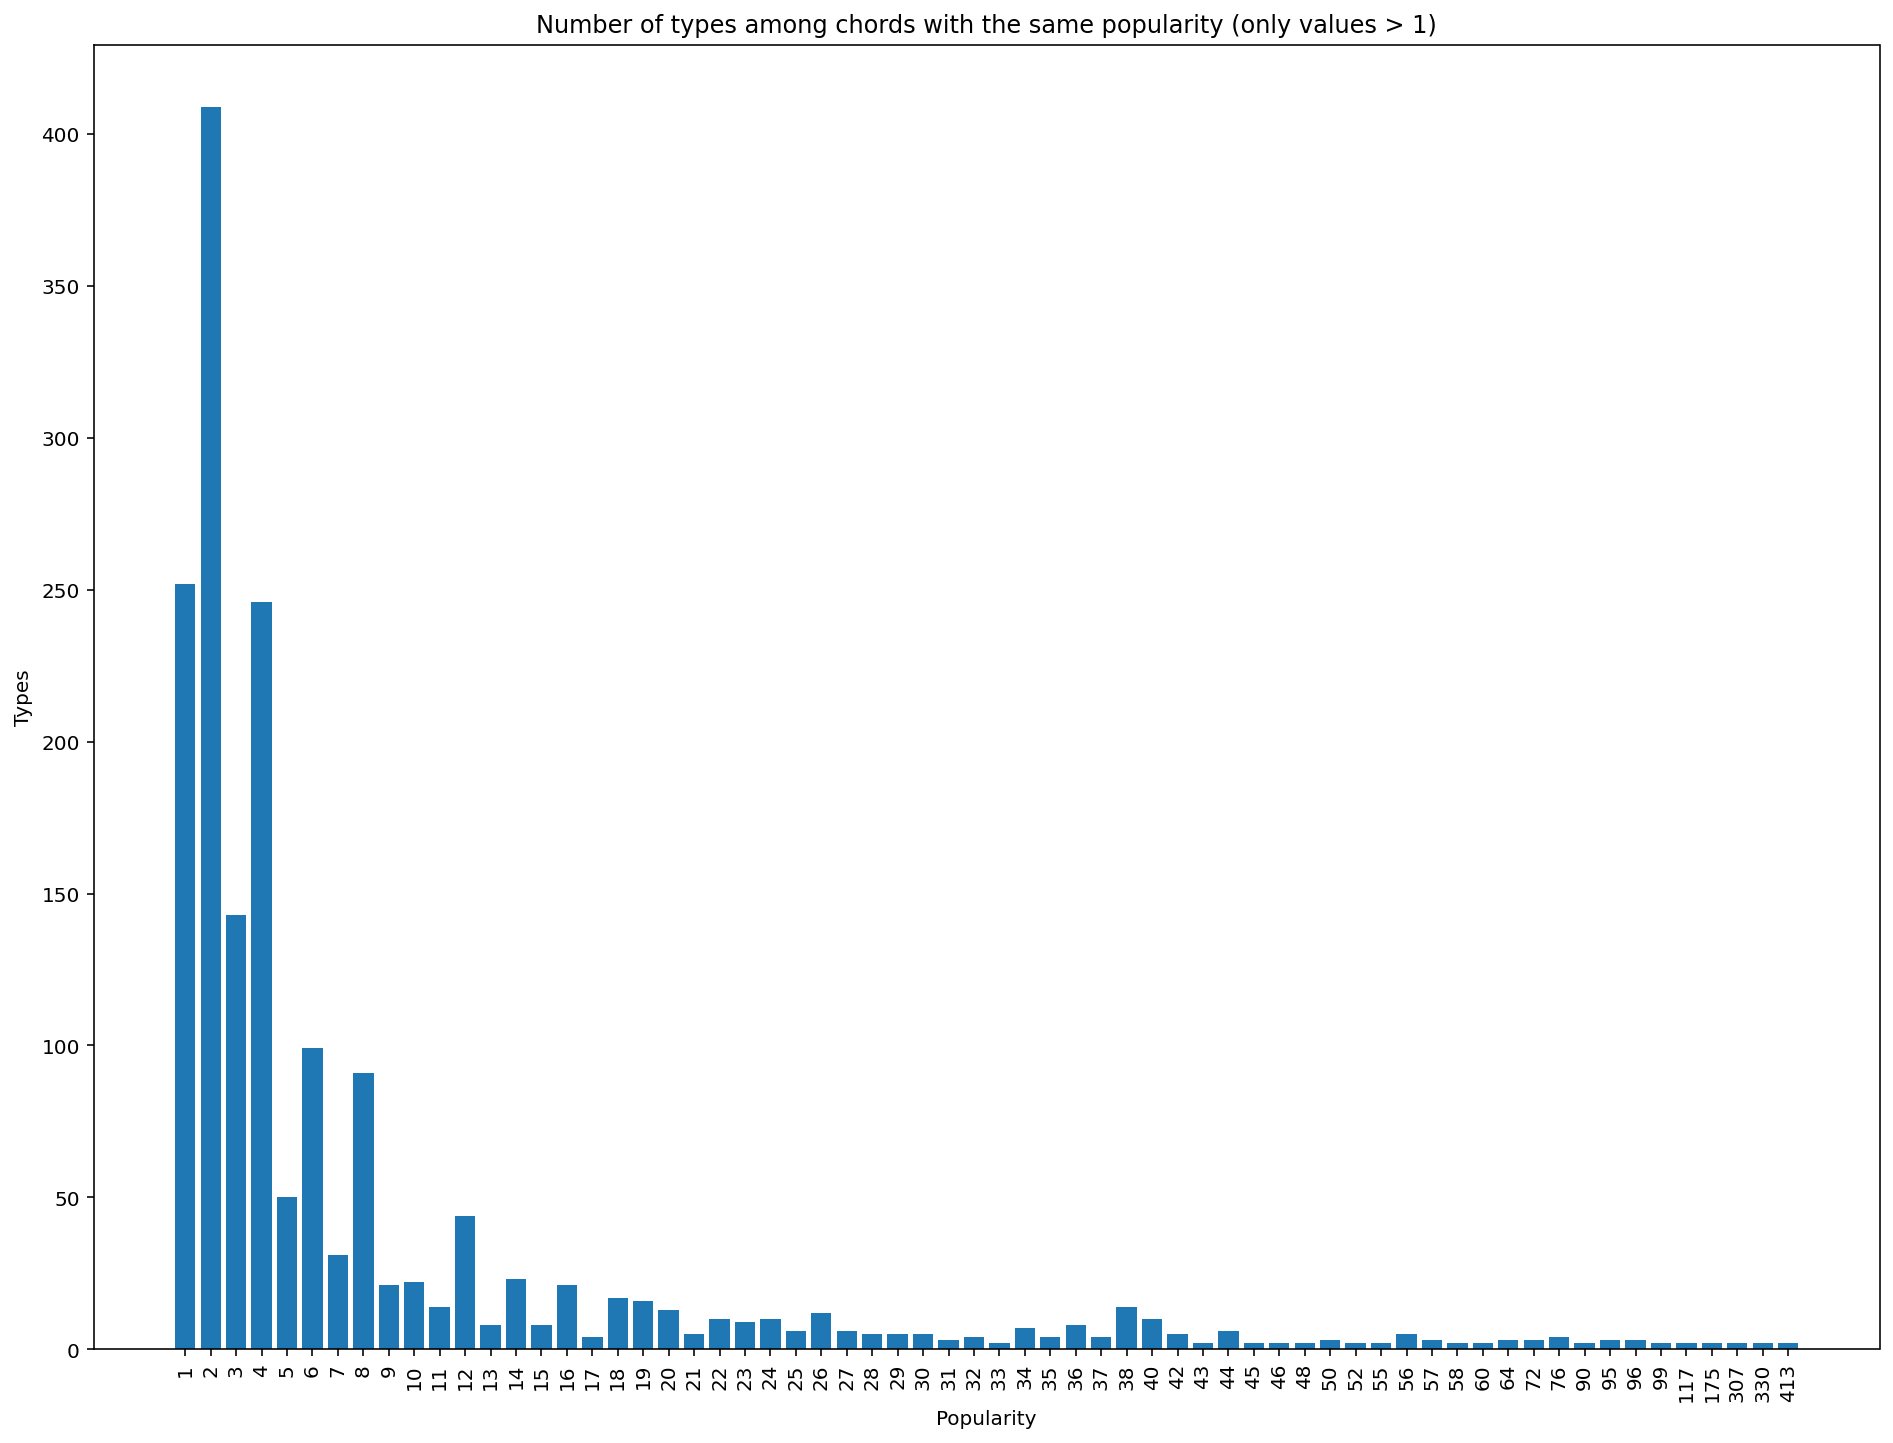

In [16]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [17]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

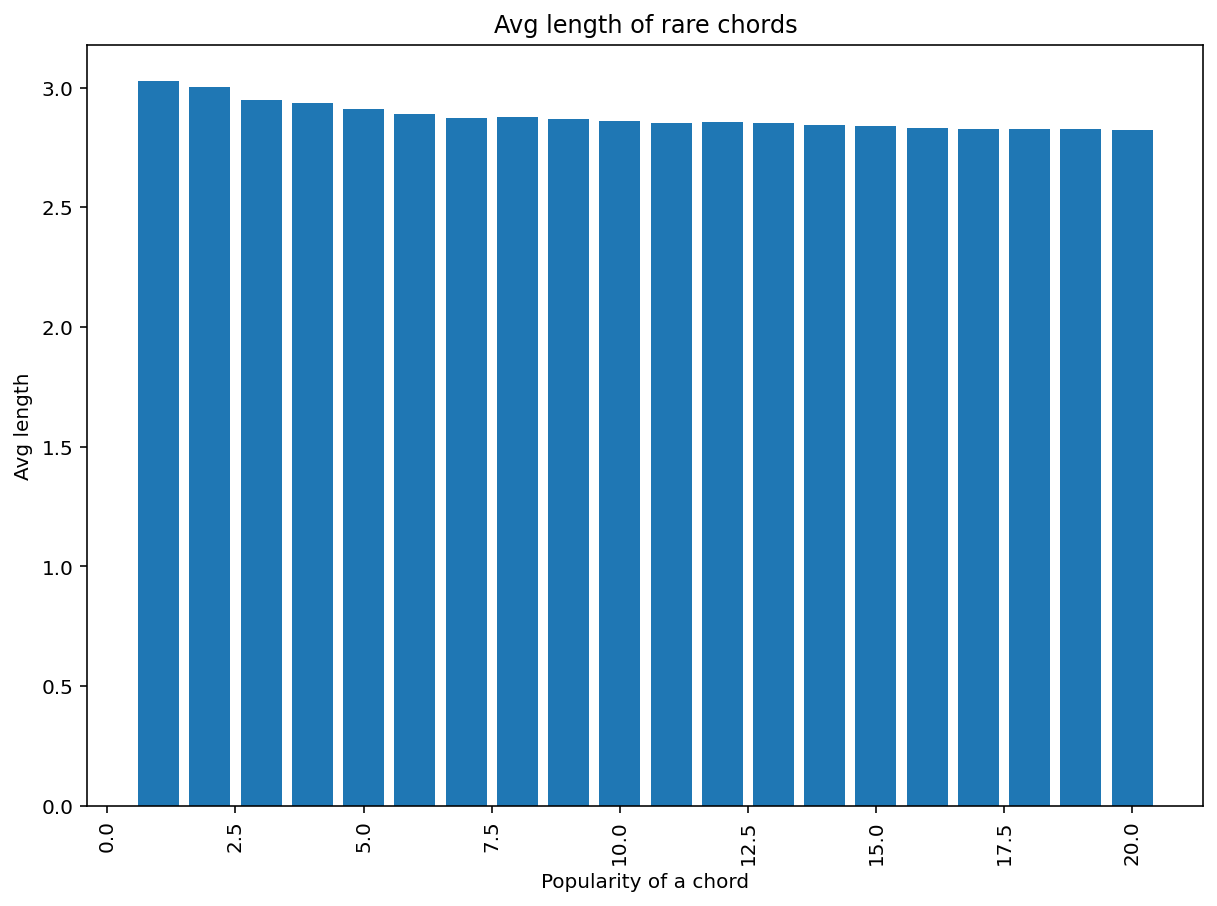

In [18]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

## Visualization

In [19]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
    try:
        filename = music.write('mid')
        os.system(f'fluidsynth -ni font.sf2 {filename} -F {filename}.wav -r 16000 > /dev/null')
        display(Audio(f'{filename}.wav'))
    except Exception as e:
        print(f'Error: {e}')

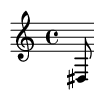

In [20]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(Fraction(1, 3))
show(n)

In [21]:
play(n)

In [22]:
from music21 import chord
def create_midi_part(melody: list) -> list:
  melody_ready = []
  # Create really ugly and unnecessary for loop just for 
  for sound in melody:
    if len(sound[1]) <= 4:
      new_note = note.Note(int(float(sound[1])), quarterLength = sound[2]) # use .nameWithOctave for the names only
    else:
      pitches_str = sound[1].split()
      pitches = [int(float(s)) for s in pitches_str]
      new_note = chord.Chord(pitches, quarterLength = sound[2]) # Must be an int (despite the fact that GPT says otherwise)
    new_note.offset = sound[0]
    melody_ready.append(new_note)
  return melody_ready

In [23]:
melody_visual = create_midi_part(get_all_notes(midi_list[1]))
melody_midi = stream.Stream(melody_visual)

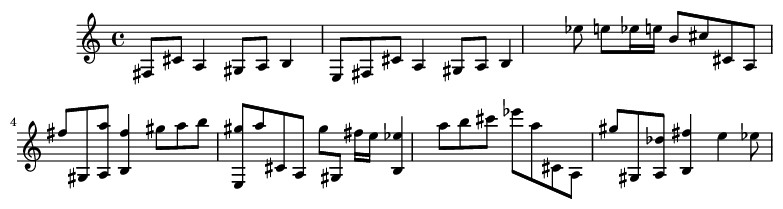

In [24]:
show(melody_midi[:50])

In [25]:
play(melody_midi[:100])

## Simpifying chords and encoding

In [26]:
LIMIT = 8 # Rare chord is shorter or equal to limit
TRIM_TO = 9 # Reduces rare chords to 2 notes
TRIM_TO = TRIM_TO if (TRIM_TO - 4) % 5 == 0 else 9 # Choose correct trim
REMOVE_PAUSES = True # Remove pauses (encoded as 0 by default) from the encoded piece
# Pauses create problems during dataset windowing

In [27]:
### Check if removing rare chords helps
ENCODER = dict() # checking if trimming chords makes any sense at all + creating id for each chord
TRIMMER = dict() # enables transformation of chords
id = 1
for key, value in types.items(): 
  kcp = key[:TRIM_TO] if value <= LIMIT and len(key) > TRIM_TO else key
  TRIMMER[key] = kcp
  if ENCODER.get(kcp) is None:
    ENCODER[kcp] = id
    id += 1

print(len(types), len(ENCODER))

1809 1142


### Encoding and decoding

In [28]:
notes_list[:10]

array([[0.0, '62.0', 0.25],
       [0.25, '62.0', 0.25],
       [0.5, '74.0', 0.25],
       [1.0, '69.0', 0.25],
       [1.75, '68.0', 0.25],
       [2.25, '67.0', 0.25],
       [2.75, '65.0', 0.5],
       [3.25, '62.0', 0.25],
       [3.5, '65.0', 0.25],
       [3.75, '67.0', 0.25]], dtype=object)

In [103]:
# Warning!!! This method removes rare chords, so the encoded version may not be the same
# Pause id -> pause

def encode_part(notes: list, chord_trans: dict, chords_id: dict, pause_id: int = 0) -> list:
  sound_list = list()
  length_list = list()
  for index, value in enumerate(notes[:-1]):
    # Calculate len of the note and offset difference between notes
    ln = int(value[2] * 12)
    if ln <= 0: # For some reason I still have notes of length 0 in my array
      continue
    offset_dif = int(12 * (notes[index + 1][0] - value[0]))
    # Encode note/chord and add it to respective list
    new_symbol = chords_id[chord_trans[value[1]]]
    sound_list.append(new_symbol)
    length_list.append(ln)
    # If there is a pause after a note add pause_id to sound_list
    if ln < offset_dif:
      sound_list.append(pause_id)
      length_list.append(offset_dif - ln)

  new_symbol = chords_id[chord_trans[value[1]]]
  sound_list.append(new_symbol)
  length_list.append(ln)
    
  return sound_list, length_list

In [104]:
notes, lens = encode_part(get_all_notes(midi_list[1]), TRIMMER, ENCODER)
notes[:20], lens[:20]

([650,
  799,
  725,
  697,
  725,
  764,
  0,
  602,
  650,
  799,
  725,
  697,
  725,
  764,
  1015,
  1028,
  1015,
  1028,
  968,
  993],
 [6, 6, 12, 6, 6, 12, 18, 6, 6, 6, 12, 6, 6, 12, 6, 6, 3, 3, 6, 6])

In [105]:
# Transform notes of len 1/3 into python fractions
def float_to_fraction(x: float):
    frac = Fraction(x).limit_denominator()
    return frac if (frac.denominator % 3 == 0 and frac.numerator % frac.denominator != 0) else x

print(float_to_fraction(0.25), float_to_fraction(0.3333333333333))

0.25 1/3


In [106]:
def decode_part(notes: list, lenghts: list, chords_id_encoder: dict, empty_id: int = 1, pause_id: int = 0) -> list:
  offset = 0
  notes_decoded = list()
  for z in zip(notes, lenghts):
    if z[0] != pause_id:
      notes_decoded.append([offset, chords_id_encoder[z[0]], float_to_fraction(z[1] / 12)])
    offset += float_to_fraction(z[1] / 12)
  return notes_decoded

In [107]:
# Create decoder dictionary
DECODER = {v: k for k, v in ENCODER.items()}

In [108]:
notes_dec = decode_part(notes, lens, DECODER)
notes_dec[:10]

[[0, '54.0', 0.5],
 [0.5, '61.0', 0.5],
 [1.0, '57.0', 1.0],
 [2.0, '56.0', 0.5],
 [2.5, '57.0', 0.5],
 [3.0, '59.0', 1.0],
 [5.5, '52.0', 0.5],
 [6.0, '54.0', 0.5],
 [6.5, '61.0', 0.5],
 [7.0, '57.0', 1.0]]

## Windowing and creating train-test split

### Windowing

In [109]:
# Predict one note/pause using 8 preceding notes, train-test split = 80%
HORIZON = 1
WINDOW_SIZE = 8
TRAIN_TEST = 0.8
MIN_PIECE_LEN = WINDOW_SIZE + HORIZON

In [110]:
# Create function to label windowed data
def get_labelled_windows(x: np.ndarray, horizon=12):
  return x[:, :-horizon], x[:, -horizon:]

In [111]:
def make_windows(x: np.ndarray, window_size: int = WINDOW_SIZE, horizon: int = HORIZON, step: int = None) -> np.ndarray:
  # 0. By default step == window_size
  step = horizon if step is None else step

  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Use numpy indexing to create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).transpose()
  # len(x)-(window_size+horizon-1) is used to prevent sliding window from getting out of range
  # Basically for some reason the sum of [[0, 1, 2]] and [[0], [1], [2]] gives you [[0, 1, 2], [1, 2, 3], [2, 3, 4]]

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Divide widowed data
  if step > 1:
    windowed_array = windowed_array[::step]

  # 5. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [112]:
test_windows, test_labels = make_windows(np.array(notes), window_size = WINDOW_SIZE, horizon = HORIZON)

In [113]:
test_windows[:3]

array([[650, 799, 725, 697, 725, 764,   0, 602],
       [799, 725, 697, 725, 764,   0, 602, 650],
       [725, 697, 725, 764,   0, 602, 650, 799]])

In [114]:
test_labels[:2]

array([[650],
       [799]])

### Joining encoded midis

In [115]:
X_set_notes = None
y_set_notes = None
X_set_lens = None
y_set_lens = None
  
for midi in midi_list:
  notes_full = get_all_notes(midi)
  if len(notes_full) < MIN_PIECE_LEN:
    continue

  notes_encoded, lens_encoded = encode_part(notes_full, TRIMMER, ENCODER)

  windows_notes, labels_notes = make_windows(np.array(notes_encoded), 
                                   window_size = WINDOW_SIZE, 
                                   horizon = HORIZON)
  
  windows_lens, labels_lens = make_windows(np.array(lens_encoded), 
                                   window_size = WINDOW_SIZE, 
                                   horizon = HORIZON)

  if X_set_notes is None:
    X_set_notes = windows_notes
    y_set_notes = labels_notes
    X_set_lens = windows_lens
    y_set_lens = labels_lens
  else:
    X_set_notes = np.concatenate([X_set_notes, windows_notes])
    y_set_notes = np.concatenate([y_set_notes, labels_notes])
    X_set_lens = np.concatenate([X_set_lens, windows_lens])
    y_set_lens = np.concatenate([y_set_lens, labels_lens])

In [116]:
len(X_set_notes), len(y_set_notes), len(X_set_lens), len(y_set_lens)

(50949, 50949, 50949, 50949)

In [123]:
np.unique(X_set_lens)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  20,  21,  24,  25,  27,  28,  30,  36,  38,
        42,  43,  44,  45,  47,  48,  51,  57,  60,  61,  69,  72,  84,
        91,  93,  96,  99, 108, 132, 139, 150, 176, 180, 192, 196, 207,
       210])

In [122]:
np.unique(X_set_notes)

array([   0,    2,    3, ..., 1140, 1141, 1142])

### Train-test split

In [117]:
divider = int(len(X_set_notes) * TRAIN_TEST)

X_set_notes_train = X_set_notes[:divider]
X_set_notes_test = X_set_notes[divider:]
y_set_notes_train = y_set_notes[:divider]
y_set_notes_test = y_set_notes[divider:]
X_set_lens_train = X_set_lens[:divider]
X_set_lens_test = X_set_lens[divider:]
y_set_lens_train = y_set_lens[:divider]
y_set_lens_test = y_set_lens[divider:]

In [118]:
len(X_set_notes_train), len(X_set_notes_test)

(40759, 10190)

In [186]:
print(f"Notes_X:\n {X_set_notes_train[:5]}\n\n", 
      f"Notes_y:\n {y_set_notes_train[:5]}\n\n", 
      f"Lens_X:\n {X_set_lens_train[:5]}\n\n", 
      f"Lens_y:\n {y_set_lens_train[:5]}")

Notes_X:
 [[ 799  872    0 1015 1064  781  836    0]
 [ 872    0 1015 1064  781  836    0 1080]
 [   0 1015 1064  781  836    0 1080 1080]
 [1015 1064  781  836    0 1080 1080  836]
 [1064  781  836    0 1080 1080  836    0]]

 Notes_y:
 [[1080]
 [1080]
 [ 836]
 [   0]
 [ 743]]

 Lens_X:
 [[6 3 9 3 3 6 3 3]
 [3 9 3 3 6 3 3 3]
 [9 3 3 6 3 3 3 3]
 [3 3 6 3 3 3 3 3]
 [3 6 3 3 3 3 3 3]]

 Lens_y:
 [[3]
 [3]
 [3]
 [3]
 [6]]


First try: no one hot encoding (memory complexity issues + capturing relations between different lengths)  



## LSTM
I was wandering if using concatenate layer would be a good idea, but ultimately I chose simpler approach

### Model layout

In [194]:
from tensorflow.keras import layers
from tensorflow import expand_dims
import tensorflow as tf

tf.random.set_seed(91)

In [126]:
X_set_notes_train.shape, y_set_notes_train.shape

((40759, 8), (40759, 1))

In [138]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [192]:
x = tf.constant(X_set_notes_train[0])
x.shape, expand_dims_layer(x).shape

(TensorShape([8]), TensorShape([8, 1]))

LSTM - notes

In [189]:
input_notes = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float32) 

x_notes = expand_dims_layer(input_notes)
x_notes = layers.LSTM(128, activation="relu")(x)
x_notes = layers.Dropout(0.1)(x_notes)
x_notes = layers.LSTM(128)(x_notes)
x_notes = layers.Dropout(0.1)(x_notes)
x_notes = layers.Dense(32)(x_notes)
output_notes = layers.Dense(units=HORIZON, activation="softmax")(x_notes)

model_notes = tf.keras.Model(inputs = input_notes, outputs = output_notes, name="model_notes")

ValueError: ignored

LSTM_2 - lengths

In [146]:
input_lens = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float32)

x_lens = expand_dims_layer(input_lens)
x_lens = layers.LSTM(128, return_sequences=True)(x_lens)
x_lens = layers.Dropout(0.1)(x_lens)
x_lens = layers.LSTM(128)(x_lens)
x_lens = layers.Dropout(0.1)(x_lens)
x_lens = layers.Dense(32)(x_lens)
output_lens = layers.Dense(units=HORIZON, activation="softmax")(x_lens)

model_lens = tf.keras.Model(inputs = input_lens, outputs = output_lens, name="model_lens")

In [147]:
model_notes.summary()

Model: "model_notes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 8)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 8)              0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 128)            70144     
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                

In [148]:
model_lens.summary()

Model: "model_lens"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 8)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 8)              0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 128)            70144     
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4

In [177]:
%%time
model_notes.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

history_lstm_notes = model_notes.fit(x=X_set_notes_train, 
                                     y=y_set_notes_train,
                                     epochs=10,
                                     verbose=0,
                                     validation_data=(X_set_notes_test, y_set_notes_test))

CPU times: user 1min 46s, sys: 5.95 s, total: 1min 52s
Wall time: 2min 25s


In [152]:
%%time
model_lens.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

history_lstm_lens = model_lens.fit(train_dataset_lens,
                              epochs=10,
                              verbose=0,
                              validation_data=test_dataset_lens)

CPU times: user 54.6 s, sys: 2.42 s, total: 57 s
Wall time: 1min 5s


### Learning curves

In [153]:
import seaborn as sns
import pandas as pd

[Text(0.5, 0, 'Epochs')]

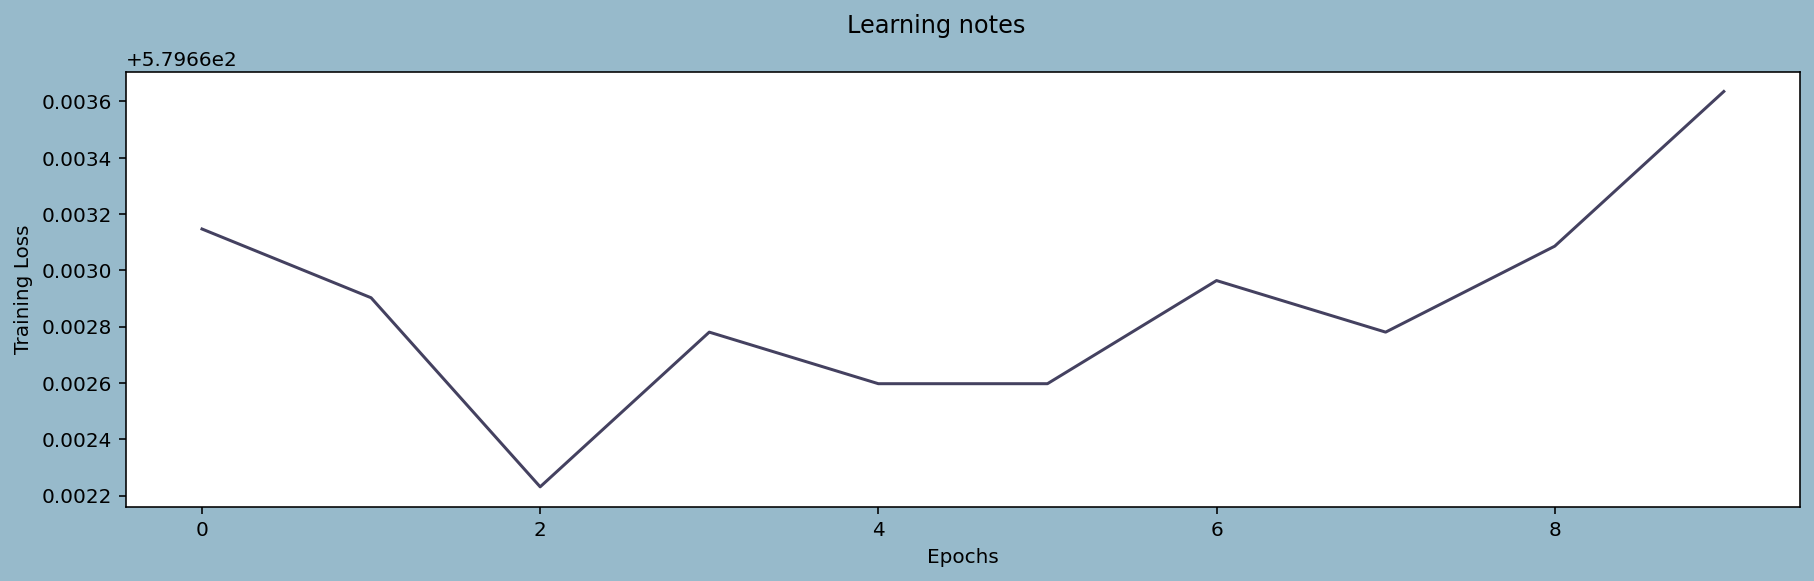

In [178]:
history_df = pd.DataFrame(history_lstm_notes.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning notes")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [180]:
history_df

,loss,mae,mse,val_loss,val_mae,val_mse
0,579.663147,579.663147,492162.59375,648.099243,648.099243,551442.625
1,579.662903,579.662903,492162.40625,648.099243,648.099243,551442.625
2,579.662231,579.662231,492162.43750,648.099243,648.099243,551442.625
3,579.662781,579.662781,492162.25000,648.099243,648.099243,551442.625
4,579.662598,579.662598,492163.06250,648.099243,648.099243,551442.625
5,579.662598,579.662598,492162.65625,648.099243,648.099243,551442.625
6,579.662964,579.663025,492162.59375,648.099243,648.099243,551442.625
7,579.662781,579.662781,492163.06250,648.099243,648.099243,551442.625
8,579.663086,579.663086,492162.59375,648.099243,648.099243,551442.625
9,579.663635,579.663635,492162.43750,648.099243,648.099243,551442.625


[Text(0.5, 0, 'Epochs')]

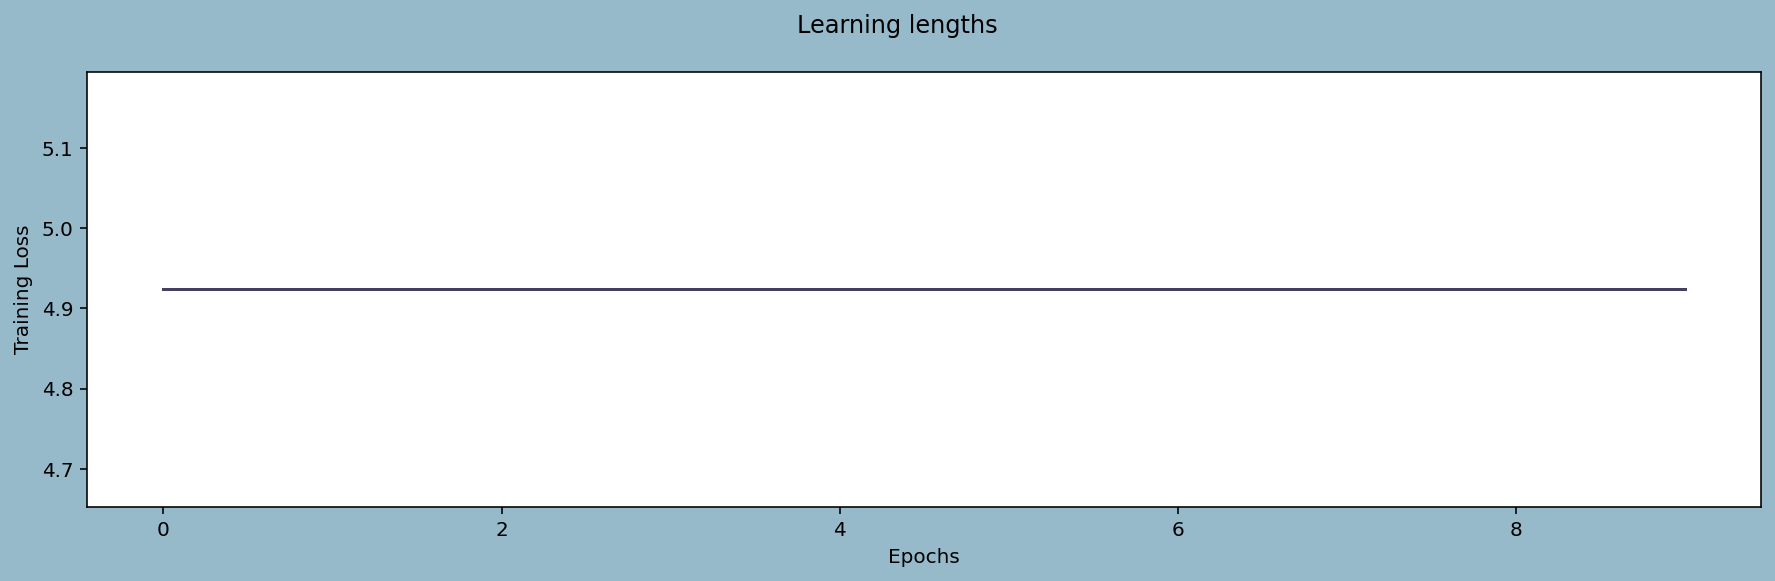

In [156]:
history_df = pd.DataFrame(history_lstm_lens.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning lengths")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

It turns out my model is learning nothing new...

In [157]:
history_df

,loss,mae,mse,val_loss,val_mae,val_mse
0,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
1,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
2,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
3,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
4,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
5,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
6,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
7,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
8,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504
9,4.92387,4.92387,54.57082,4.200589,4.200589,65.194504


### Making predictions

ValueError: ignored

In [182]:
forecast

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)